In [1]:
import pandas as pd
import numpy as np

from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from gensim.models import KeyedVectors

Using TensorFlow backend.


In [2]:
# import dataset
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

In [3]:
data.tail()

,Sentence #,Word,POS,Tag
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [4]:
# get all unique words
words = list(pd.unique(data.Word.values))
n_words = len(words); n_words

35178

In [5]:
words[75:85]

['resort',
 'Brighton',
 'party',
 'is',
 'divided',
 'over',
 'participation',
 'continued',
 'deployment',
 '8,500']

In [6]:
# get all unique "Tag"s
tags = pd.unique(data.Tag)
n_tags = len(tags); n_tags

17

In [7]:
class SentenceGetter(object):
    
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(data)

In [9]:
sent = getter.get_next()

In [10]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [11]:
len(sent)

24

In [12]:
sentences = getter.sentences

In [13]:
lengths = []

for sentence in sentences:
    lengths.append(len(sentence))

In [14]:
print("Min: ", np.min(lengths))
print("Max: ", np.max(lengths))
print("Mean: ",np.mean(lengths))

Min:  1
Max:  104
Mean:  21.863987989741236


In [89]:
# define max length
max_len = 75

# define max length for label
max_size = 25

In [16]:
word2idx = {w: i+2 for i,w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0

In [17]:
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [18]:
print(word2idx["Obama"])
print(tag2idx["B-geo"])

2196
2


In [19]:
# pad the sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences]

X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

In [20]:
X_word.shape

(47959, 75)

In [90]:
# pad the output label
y = [[tag2idx[w[2]] for w in s] for s in sentences]

y = pad_sequences(maxlen=max_size, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')


In [91]:
y.shape

(47959, 25)

In [92]:
X_word[0]

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 11, 17,
        3, 18, 19, 20, 21, 22, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0])

In [93]:
y[0]

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       1, 1, 0])

In [94]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)

In [95]:
# Initialize Embedding layer with pre-trained word2vec model
model = KeyedVectors.load_word2vec_format("C:\\Word2Vec_Models\\GoogleNews-vectors-negative300.bin", binary=True)

In [96]:
EMBEDDING_DIM = 300

embedding_matrix = np.zeros((len(words) + 2, EMBEDDING_DIM))
for word, i in word2idx.items():
    try:
        embedding_vector = model[word]
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    except:
        pass

In [97]:
# Define Embedding Model
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, Convolution1D, Conv2D, Convolution2D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D, MaxPooling1D

In [98]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=max_len)(word_in)

In [99]:
# character LSTM to get word encodings by characters
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6), name="blstm")(emb_word)

In [100]:
main_cnn = Conv1D(75,kernel_size=3, padding="same",name="conv1d")(main_lstm)
main_cnn = MaxPooling1D(3)(main_cnn)

In [101]:
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"), name="timed_softmax")(main_cnn)

In [102]:
model = Model(word_in, out)

In [103]:
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 75, 300)           10554000  
_________________________________________________________________
blstm (Bidirectional)        (None, 75, 100)           140400    
_________________________________________________________________
conv1d (Conv1D)              (None, 75, 75)            22575     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 25, 75)            0         
_________________________________________________________________
timed_softmax (TimeDistribut (None, 25, 18)            1368      
Total params: 10,718,343
Trainable params: 10,718,343
Non-trainable params: 0
______________________________________________

In [114]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [115]:
n_epoch = 20
history = model.fit(X_word_tr, np.array(y_tr).reshape(len(y_tr), max_size, 1),
                    batch_size=256, epochs=n_epoch, validation_split=0.1, verbose=1)

C:\Users\dtecitak\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38846 samples, validate on 4317 samples
Epoch 1/20
38846/38846 [==============================] - 151s 4ms/step - loss: 0.3903 - acc: 0.8940 - val_loss: 0.4013 - val_acc: 0.8927
Epoch 2/20
38846/38846 [==============================] - 158s 4ms/step - loss: 0.3680 - acc: 0.8969 - val_loss: 0.3913 - val_acc: 0.8928
Epoch 3/20
38846/38846 [==============================] - 157s 4ms/step - loss: 0.3499 - acc: 0.8993 - val_loss: 0.3904 - val_acc: 0.8918
Epoch 4/20
38846/38846 [==============================] - 159s 4ms/step - loss: 0.3347 - acc: 0.9014 - val_loss: 0.3875 - val_acc: 0.8930
Epoch 5/20
38846/38846 [==============================] - 162s 4ms/step - loss: 0.3210 - acc: 0.9040 - val_loss: 0.3885 - val_acc: 0.8928
Epoch 6/20
38846/38846 [==============================] - 161s 4ms/step - loss: 0.3075 - acc: 0.9065 - val_loss: 0.3914 - val_acc: 0.8927
Epoch 7/20
38846/38846 [==============================] - 160s 4ms/step - loss: 0.2957 - acc: 0.9088 - val_loss: 0.3976 - v

KeyboardInterrupt: 

In [116]:
hist = pd.DataFrame(history.history)

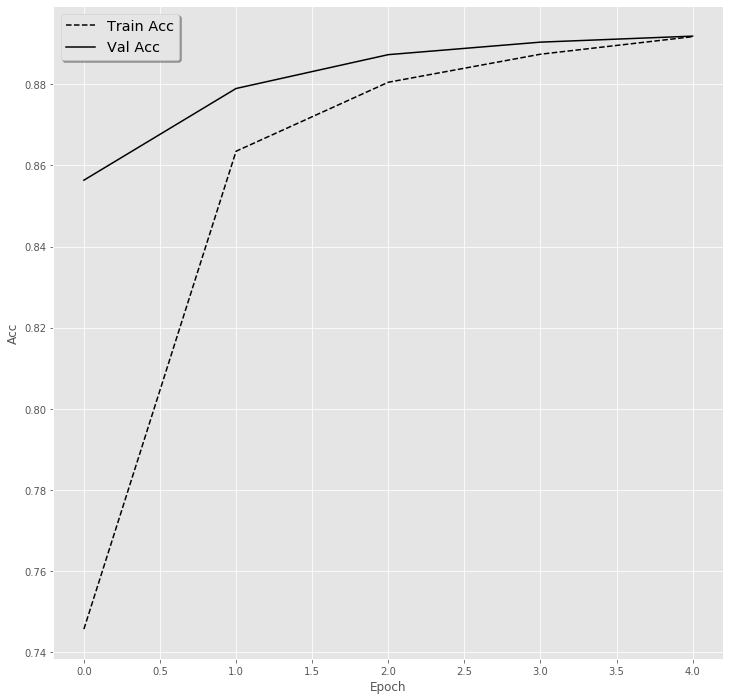

In [117]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"],'k--', label='Train Acc')
plt.plot(hist["val_acc"],'k', label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Acc")

legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')

plt.show()

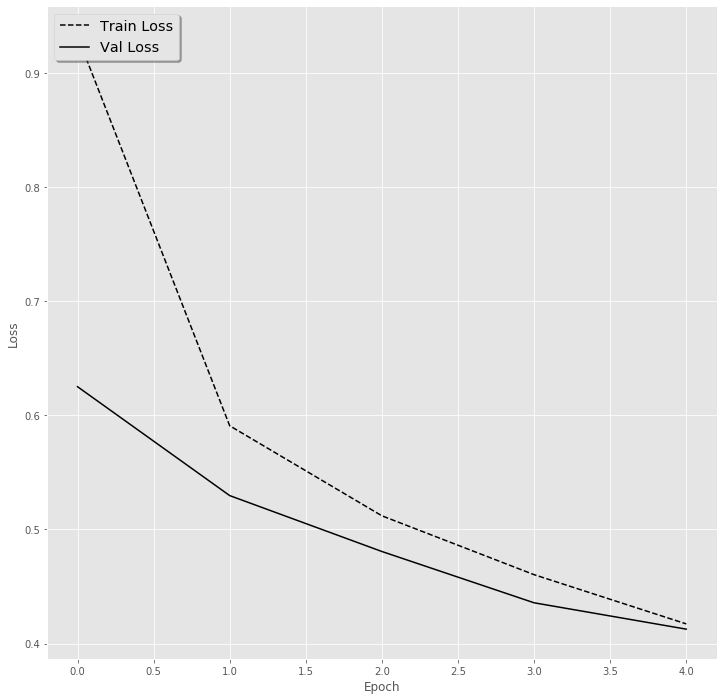

In [118]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"],'k--', label='Train Loss')
plt.plot(hist["val_loss"],'k', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")

legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')

plt.show()

In [119]:
y_pred = model.predict(X_word_te,max_len,1)

4796/4796 [==============================] - 5s 1ms/step


In [120]:
y_pred.shape

(4796, 25, 18)

In [121]:
y_pred_logit = np.argmax(y_pred, axis=-1)

In [122]:
i = 2
p = np.argmax(y_pred[i], axis=-1)

print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True ||Pred
A              : O     O
statement      : O     O
from           : O     O
the            : O     O
medical        : O     O
center         : O     O
in             : O     O
Cleveland      : B-geo O
says           : O     O
Mr.            : B-per O
Carter         : I-per O
left           : O     O
the            : O     O
hospital       : O     O
after          : O     O
midday         : B-tim O
Thursday       : I-tim O
.              : O     O
